In [ ]:
import cv2 as cv
import glob
import math
import os
from pathlib import Path
import numpy as np
from typing import Tuple, List, Optional, Dict
import matplotlib.pyplot as plt

IMG_DIR = "coco_images"
TARGET_SIZE = (320, 240)
PATCH = 64
MAX_JITTER = 16
BINS = 21
DTYPE = np.float32

In [3]:
def _to_gray_uchar(img_bgr: np.ndarray) -> np.ndarray:
    if img_bgr.ndim == 3 and img_bgr.shape[2] == 3:
        g = cv.cvtColor(img_bgr, cv.COLOR_BGR2GRAY)
    elif img_bgr.ndim == 2:
        g = img_bgr
    else:
        raise ValueError("Unsupported image format")
    return g

def _load_and_preprocess(path: str, target_size: Tuple[int, int]) -> np.ndarray:
    img = cv.imread(path, cv.IMREAD_COLOR)
    if img is None:
        raise IOError(f"Failed to read image: {path}")
    img = cv.resize(img, target_size, interpolation=cv.INTER_AREA)
    g = _to_gray_uchar(img)
    return g

def _random_window(rng: np.random.Generator, W: int, H: int, patch: int, margin: int) -> Tuple[int, int]:
    x = rng.integers(margin, W - patch - margin + 1)
    y = rng.integers(margin, H - patch - margin + 1)
    return int(x), int(y)

def _perturb_corners(rng: np.random.Generator, x: int, y: int, patch: int, max_jitter: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    tl = np.array([x,         y        ], dtype=np.float32)
    tr = np.array([x + patch, y        ], dtype=np.float32)
    br = np.array([x + patch, y + patch], dtype=np.float32)
    bl = np.array([x,         y + patch], dtype=np.float32)
    pts_src = np.stack([tl, tr, br, bl], axis=0)

    jit = rng.integers(-max_jitter, max_jitter + 1, size=(4, 2)).astype(np.float32)
    pts_dst = pts_src + jit
    offsets = (pts_dst - pts_src).reshape(-1)
    return pts_src, pts_dst, offsets

def _safe_margin_for_jitter(max_jitter: int) -> int:
    # We keep enough margin so that the quadrilateral remains within image after perturbation.
    # A conservative choice is max_jitter to each side.
    return max_jitter

def _compute_warp_and_apply(gray: np.ndarray, pts_src: np.ndarray, pts_dst: np.ndarray) -> np.ndarray:
    H = cv.getPerspectiveTransform(pts_src.astype(np.float32), pts_dst.astype(np.float32))
    H_inv = np.linalg.inv(H)
    warped = cv.warpPerspective(gray, H_inv, (gray.shape[1], gray.shape[0]), flags=cv.INTER_LINEAR, borderMode=cv.BORDER_REPLICATE)
    return warped

def _crop(gray: np.ndarray, x: int, y: int, patch: int) -> np.ndarray:
    return gray[y:y+patch, x:x+patch]

def _stack_two_channel(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    a = (a.astype(DTYPE) / 255.0)
    b = (b.astype(DTYPE) / 255.0)
    return np.stack([a, b], axis=0)

def _bin_centers(bins: int, max_jitter: int) -> np.ndarray:
    return np.linspace(-max_jitter, max_jitter, bins, dtype=DTYPE)

def quantize_offsets(offsets_8: np.ndarray, bins: int = BINS, max_jitter: int = MAX_JITTER) -> np.ndarray:
    centers = _bin_centers(bins, max_jitter)
    idxs = []
    for v in offsets_8.astype(DTYPE):
        i = int(np.argmin(np.abs(centers - v)))
        idxs.append(i)
    return np.array(idxs, dtype=np.int64)

def one_hot_8xB(class_idxs_8: np.ndarray, bins: int = BINS) -> np.ndarray:
    y = np.zeros((8, bins), dtype=DTYPE)
    for i, c in enumerate(class_idxs_8):
        y[i, c] = 1.0
    return y
def generate_sample_from_image(gray_240x320: np.ndarray,
                               rng: Optional[np.random.Generator] = None,
                               patch: int = PATCH,
                               max_jitter: int = MAX_JITTER,
                               return_cls: bool = True) -> Dict[str, np.ndarray]:
    if rng is None:
        rng = np.random.default_rng()

    H_img, W_img = gray_240x320.shape[:2]
    margin = _safe_margin_for_jitter(max_jitter)
    x, y = _random_window(rng, W_img, H_img, patch, margin)

    pts_src, pts_dst, offsets = _perturb_corners(rng, x, y, patch, max_jitter)
    H = cv.getPerspectiveTransform(pts_src.astype(np.float32), pts_dst.astype(np.float32))
    H_inv = np.linalg.inv(H)
    warped = cv.warpPerspective(gray_240x320, H_inv, (W_img, H_img), flags=cv.INTER_LINEAR, borderMode=cv.BORDER_REPLICATE)

    crop_a = _crop(gray_240x320, x, y, patch)
    crop_b = _crop(warped,       x, y, patch)
    x2 = _stack_two_channel(crop_a, crop_b)

    out = {
        "x": x2,
        "y_reg": offsets.astype(DTYPE),
        "H": H.astype(DTYPE),
        "xy": np.array([x, y], dtype=np.int32),
    }
    if return_cls:
        idxs = quantize_offsets(offsets, bins=BINS, max_jitter=max_jitter)
        out["y_cls_idx"] = idxs
        out["y_cls_oh"] = one_hot_8xB(idxs, bins=BINS)
    return out

def image_paths_from_dir(img_dir: str, exts: Tuple[str, ...] = (".jpg", ".jpeg", ".png")) -> List[str]:
    ps = []
    for e in exts:
        ps.extend(glob.glob(os.path.join(img_dir, f"*{e}")))
    return sorted(ps)

# -----------------------
# Public API
# -----------------------
class HomographyDatasetOnTheFly:
    def __init__(self,
                 img_dir: str = IMG_DIR,
                 seed: Optional[int] = None,
                 patch: int = PATCH,
                 max_jitter: int = MAX_JITTER,
                 return_cls: bool = True):
        self.paths = image_paths_from_dir(img_dir)
        if not self.paths:
            raise RuntimeError(f"No images found in {img_dir}")
        self.rng = np.random.default_rng(seed)
        self.patch = patch
        self.max_jitter = max_jitter
        self.return_cls = return_cls

    def __len__(self):
        return len(self.paths)

    def _rand_img(self) -> np.ndarray:
        p = self.paths[self.rng.integers(0, len(self.paths))]
        g = _load_and_preprocess(p, TARGET_SIZE)
        return g

    def sample(self) -> Dict[str, np.ndarray]:
        g = self._rand_img()
        return generate_sample_from_image(
            g, rng=self.rng, patch=self.patch, max_jitter=self.max_jitter, return_cls=self.return_cls
        )

def precompute_npz(out_path: str,
                   n_samples: int = 1000,
                   img_dir: str = IMG_DIR,
                   seed: Optional[int] = 123,
                   return_cls: bool = True) -> str:

    ds = HomographyDatasetOnTheFly(img_dir=img_dir, seed=seed, return_cls=return_cls)
    X = np.zeros((n_samples, 2, PATCH, PATCH), dtype=DTYPE)
    y_reg = np.zeros((n_samples, 8), dtype=DTYPE)
    if return_cls:
        y_cls_idx = np.zeros((n_samples, 8), dtype=np.int64)
        y_cls_oh  = np.zeros((n_samples, 8, BINS), dtype=DTYPE)

    for i in range(n_samples):
        s = ds.sample()
        X[i] = s["x"]
        y_reg[i] = s["y_reg"]
        if return_cls:
            y_cls_idx[i] = s["y_cls_idx"]
            y_cls_oh[i]  = s["y_cls_oh"]

    Path(os.path.dirname(out_path) or ".").mkdir(parents=True, exist_ok=True)
    if return_cls:
        np.savez_compressed(out_path, X=X, y_reg=y_reg, y_cls_idx=y_cls_idx, y_cls_oh=y_cls_oh)
    else:
        np.savez_compressed(out_path, X=X, y_reg=y_reg)
    return out_path


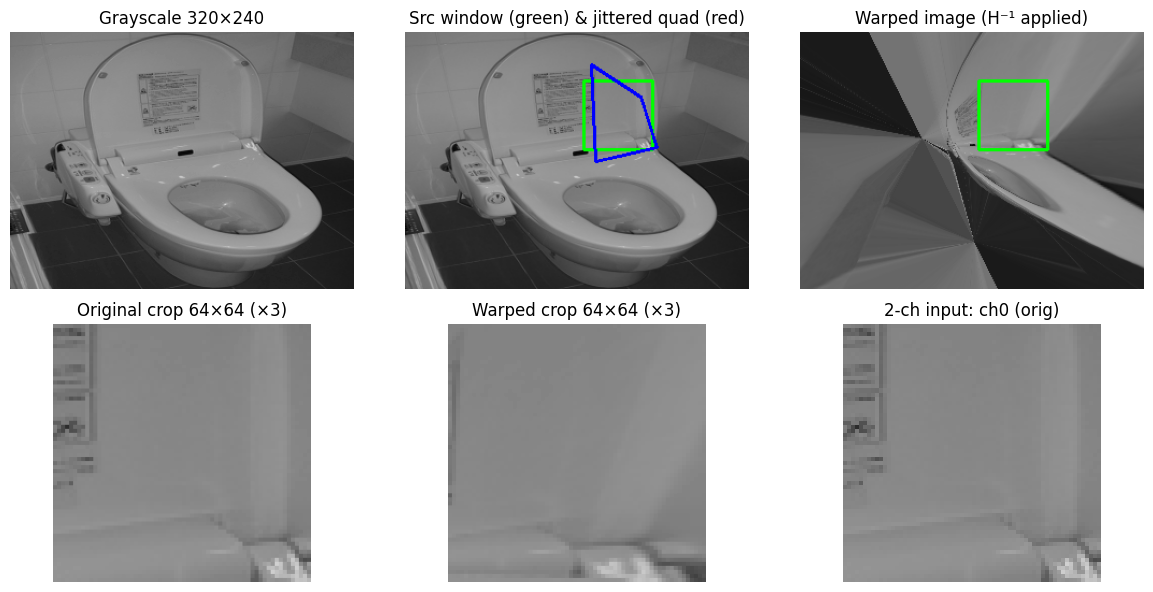

Image: coco_images/000000077020.jpg
Top-left of window: (x=166, y=46)
Offsets (dx_tl,dy_tl, dx_tr,dy_tr, dx_br,dy_br, dx_bl,dy_bl):
[  7 -15 -11  15   4  -2  11  11]
2-channel tensor shape/dtype/range: (2, 64, 64) float32 (np.float32(0.1764706), np.float32(0.8156863))


In [ ]:

# 1) Pick a random image
paths = image_paths_from_dir(IMG_DIR)
assert len(paths) > 0, f"No images found in {IMG_DIR}"
rng = np.random.default_rng()
img_path = paths[rng.integers(0, len(paths))]
gray = _load_and_preprocess(img_path, TARGET_SIZE)

# 2) Random 64×64 window away from borders
H_img, W_img = gray.shape[:2]
margin = _safe_margin_for_jitter(MAX_JITTER)
x_min, x_max = margin, W_img - PATCH - margin
y_min, y_max = margin, H_img - PATCH - margin
x = int(rng.integers(x_min, x_max + 1))
y = int(rng.integers(y_min, y_max + 1))

pts_src = np.array([[x, y],
                    [x + PATCH, y],
                    [x + PATCH, y + PATCH],
                    [x, y + PATCH]], dtype=np.float32)

# 3) Jitter the 4 corners by random offsets in [-16, 16]
jit = rng.integers(-MAX_JITTER, MAX_JITTER + 1, size=(4, 2)).astype(np.float32)
pts_dst = pts_src + jit
offsets = (pts_dst - pts_src).reshape(-1)

# 4) Compute homography
H = cv.getPerspectiveTransform(pts_src, pts_dst)
H_inv = np.linalg.inv(H)
warped = cv.warpPerspective(
    gray, H_inv, (W_img, H_img),
    flags=cv.INTER_LINEAR, borderMode=cv.BORDER_REPLICATE
)

# 5) Crop the same window from original and warped images
crop_a = _crop(gray,   x, y, PATCH)
crop_b = _crop(warped, x, y, PATCH)

# 6) Stack into 2-channel input (float32 in [0,1])
x2 = _stack_two_channel(crop_a, crop_b)  # shape (2, 64, 64)


vis_orig = cv.cvtColor(gray, cv.COLOR_GRAY2BGR)
cv.rectangle(vis_orig, (x, y), (x + PATCH, y + PATCH), (0, 255, 0), 2)  # src rect (green)
cv.polylines(vis_orig, [pts_dst.astype(np.int32)], isClosed=True, color=(255, 0, 0), thickness=2)  # dst quad (red)

vis_warp = cv.cvtColor(warped, cv.COLOR_GRAY2BGR)
cv.rectangle(vis_warp, (x, y), (x + PATCH, y + PATCH), (0, 255, 0), 2)

plt.figure(figsize=(12, 6))

plt.subplot(2, 3, 1)
plt.imshow(gray, cmap='gray', vmin=0, vmax=255)
plt.title("Grayscale 320×240")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(cv.cvtColor(vis_orig, cv.COLOR_BGR2RGB))
plt.title("Src window (green) & jittered quad (red)")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(cv.cvtColor(vis_warp, cv.COLOR_BGR2RGB))
plt.title("Warped image (H⁻¹ applied)")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(cv.resize(crop_a, (PATCH*3, PATCH*3), interpolation=cv.INTER_NEAREST),
           cmap='gray', vmin=0, vmax=255)
plt.title("Original crop 64×64 (×3)")
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(cv.resize(crop_b, (PATCH*3, PATCH*3), interpolation=cv.INTER_NEAREST),
           cmap='gray', vmin=0, vmax=255)
plt.title("Warped crop 64×64 (×3)")
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(x2[0], cmap='gray', vmin=0, vmax=1)
plt.title("2-ch input: ch0 (orig)")
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Image: {img_path}")
print(f"Top-left of window: (x={x}, y={y})")
print("Offsets (dx_tl,dy_tl, dx_tr,dy_tr, dx_br,dy_br, dx_bl,dy_bl):")
print(offsets.astype(np.int32))
print("2-channel tensor shape/dtype/range:", x2.shape, x2.dtype, (x2.min(), x2.max()))
